# Data queries - Quick start

Deep Search parses and interprets large collections of documents quickly and concurrently.
These collections are stored and indexed such that you can search and retrieve any document according to their contents.



### Access required

The content of this notebook requires access to Deep Search capabilities which are not
available on the public access system.

[Contact us](https://ds4sd.github.io/#unlimited-access) if you are interested in exploring
this Deep Search capabilities.

### Authentication via stored credentials

In this example, we initialize the Deep Search client from the credentials
contained in the file `../../ds-auth.ext-v2.json`. This can be generated with

```shell
!deepsearch login --host https://deepsearch-ext-v2-535206b87b82b5365d9d6671fbc19165-0000.us-south.containers.appdomain.cloud/ --output ../../ds-auth.ext-v2.json
```

The extra `--host` argument is required in this example to target the limited access instance

More details in the [docs](https://ds4sd.github.io/deepsearch-toolkit/getting_started/#authentication).

### Notebooks parameters

The following block defines the parameters used to execute the notebook

- `CONFIG_FILE`: location of the Deep Search configuration file


In [1]:
# Input parameters for the example flow
from pathlib import Path
CONFIG_FILE = Path("../../ds-auth.ext-v2.json")

### Import example dependencies

In [2]:
# Import standard dependenices
from copy import deepcopy
import pandas as pd
from numerize.numerize import numerize
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# IPython utilities
from IPython.display import display, Markdown, HTML, display_html

# Import the deepsearch-toolkit
import deepsearch as ds
from deepsearch.cps.client.components.elastic import ElasticDataCollectionSource
from deepsearch.cps.queries import DataQuery
from deepsearch.cps.client.components.queries import RunQueryError


### Connect to Deep Search

In [3]:
# Initialize the Deep Search client from the config file
config = ds.DeepSearchConfig.parse_file(CONFIG_FILE)
client = ds.CpsApiClient(config)
api = ds.CpsApi(client)

---

## Inspect Deep Search data

In this section we will inspect the different data collections on Deep Search and we will perform soma initial searches.

Explanation of the columns
- **Name**: The name of the data collection
- **Type**: Type of content in the data collection (see below)
- **Date**: Date of the last update on the data
- **Num entries**: Number of entries in the data collection
- **Coords**: Coordinates needed in the Deep Search Toolkit to query a specific data collection


Type of data collections
- **Document**: A collection of documents. These are either PDF documents already converted via the Deep Search document conversion, or data sources which can be mapped to the same format, e.g. the USPTO patents are obtained as sourced as XML
- **Record**: A collection of DB records in a structure database. For example, the content of PubChem is made available in this format. 

In [4]:
# Fetch list of all data collections
collections = api.elastic.list()
collections.sort(key=lambda c: c.name.lower())

In [5]:
# Visualize summary table
results = [
    {
        "Name": c.name,
        "Type": c.metadata.type,
        "Num entries": numerize(c.documents),
        "Date": c.metadata.created.strftime("%Y-%m-%d"),
        "Coords": f"{c.source.elastic_id}/{c.source.index_key}",
    }
    for c in collections
]
display(pd.DataFrame(results))

,Name,Type,Num entries,Date,Coords
0,Annual Reports,Document,72.27K,2022-11-21,default/annual-report
1,Annual Reports (metadata),Document,74.87K,2022-11-02,default/annual-report-metadata
2,arXiv abstracts,Document,2.16M,2022-11-28,default/arxiv-abstract
3,arXiv classification guide,Reference,155,2022-02-23,default/arxiv-category
4,arXiv full documents,Document,2.06M,2022-10-06,default/arxiv
5,BioRxiv,Document,291.57K,2022-10-20,materials/biorxiv
6,Brenda,Record,7.12K,2022-01-21,materials/brenda
7,CAZy,Record,8.75K,2021-12-13,materials/cazy
8,ChEMBL,Record,2.11M,2021-12-21,materials/chembl
9,ChemRxiv,Document,8.97K,2021-11-03,materials/chemrxiv


### Search among data collections

In the following section we will search count how many results we obtain in each data collection.

In [6]:
# Input query
search_query = "(\"power conversion efficiency\" OR PCE) AND organ*"

# Iterate through the data collections
results = []
for c in (pbar := tqdm(collections)):
    pbar.set_description(f"Querying {c.name}")

    # Search only on document collections
    if c.metadata.type != "Document":
        continue

    try:
        # Execute the query
        query = DataQuery(search_query, source=[""], limit=0, coordinates=c.source)
        query_results = api.queries.run(query)
        results.append({
            "name": c.name,
            "matches": query_results.outputs["data_count"]
        })
    except RunQueryError as err:
        print(f"Error with index {c.source.elastic_id}/{c.source.index_key}. {err}")

# Sort and display results
results.sort(reverse=True, key=lambda r: r["matches"])
display(pd.DataFrame(results))

  0%|          | 0/50 [00:00<?, ?it/s]

,name,matches
0,Semantic Scholar Open Research Corpus metadata,13968
1,Patents from USPTO,10428
2,PubMed,5749
3,Patents from EPO,2888
4,arXiv full documents,1833
5,Crossref,1584
6,BioRxiv,488
7,Cord19,242
8,Patents from KIPO,214
9,Annual Reports,152


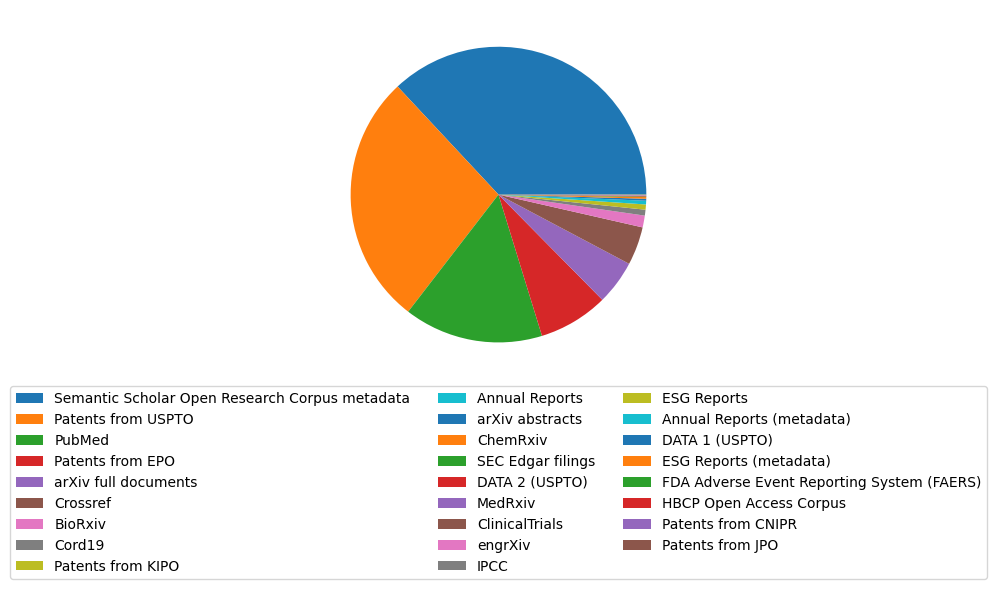

In [7]:
# Plot the distribution of results among data collections

x = [r["name"] for r in results]
y = [r["matches"] for r in results]
plt.pie(y, labels=x, labeldistance=None)
plt.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 0))

---

## Search documents

In this section we search for documents in the arXiv.org data collection matching the input query.
For each matched document we return the title, authors as well as the link to the original document on arXix.org 


This example will demonstrate
1. How to address a specific data collection
2. How to choose which component of the documents should be returned
3. How to iterate through the complete data collection by fetching `page_size=50` results at the time


In [8]:
# Input query
search_query = "(\"power conversion efficiency\" OR PCE) AND organ*"
data_collection = ElasticDataCollectionSource(elastic_id="default", index_key="arxiv")
page_size = 50

# Prepare the data query
query = DataQuery(
    search_query, # The search query to be executed
    source=["description.title", "description.authors", "identifiers"], # Which fields of documents we want to fetch
    limit=page_size, # The size of each request page
    coordinates=data_collection # The data collection to be queries
)


# [Optional] Compute the number of total results matched. This can be used to monitor the pagination progress.
count_query = deepcopy(query)
count_query.paginated_task.parameters["limit"] = 0
count_results = api.queries.run(count_query)
expected_total = count_results.outputs["data_count"]
expected_pages = (expected_total + page_size - 1) // page_size # this is simply a ceiling formula


# Iterate through all results by fetching `page_size` results at the same time
all_results = []
cursor = api.queries.run_paginated_query(query)
for result_page in tqdm(cursor, total=expected_pages):
    # Iterate through the results of a single page, and add to the total list
    for row in result_page.outputs["data_outputs"]:
        # Process custom identifiers links
        links = {"arxiv": None, "doi": None}
        identifiers = {"arxiv": None, "doi": None}
        for ids in row["_source"]["identifiers"]:
            if ids["type"] == "arxivid":
                identifiers["arxiv"] = ids["value"]
                links["arxiv"] = f'https://arxiv.org/abs/{ids["value"]}'
            if ids["type"] == "doi":
                identifiers["doi"] = ids["value"]
                links["doi"] = f'https://doi.org/{ids["value"]}'
            
        # Add row to results table
        all_results.append({
            "Title": row["_source"]["description"]["title"],
            "Authors": ", ".join([author["name"] for author in row["_source"]["description"]["authors"]]),
            "arXiv": identifiers["arxiv"],
            "arXiv URL": links["arxiv"],
            "DOI": identifiers["doi"],
            "DOI URL": links["doi"],
        })    

print(f'Finished fetching all data. Total is {len(all_results)} records.')

  0%|          | 0/37 [00:00<?, ?it/s]

Finished fetching all data. Total is 1833 records.


In [9]:
# Visualize the table with all results
df = pd.json_normalize(all_results)
display(HTML(df.head().to_html(render_links=True)))

,Title,Authors,arXiv,arXiv URL,DOI,DOI URL
0,A Charging-as-a-Service Platform for Charging Electric Vehicles On the\n Move: New Vehicle Routing Model and Solution,"Jiahua Qiu, Lili Du",2104.00730,https://arxiv.org/abs/2104.00730,None,None
1,The Transmission of US Monetary Policy Shocks: The Role of Investment &\n Financial Heterogeneity,"Santiago Camara, Sebastian Ramirez Venegas",2209.11150,https://arxiv.org/abs/2209.11150,None,None
2,On the monodromy map for the logarithmic differential systems,"Marian Aprodu, Indranil Biswas, Sorin Dumitrescu, Sebastian Heller",2201.04095,https://arxiv.org/abs/2201.04095,None,None
3,Methylammonium Lead Trihalide Perovskite Solar Cell Semiconductors Are\n Not Organometallic,Pradeep R. Varadwaj,1703.09885,https://arxiv.org/abs/1703.09885,None,None
4,A Decentralized Approach to Software-Defined Networks (SDNs),"Reza Farrahi Moghaddam, Yves Lemieux, Mohamed Cheriet",1504.07933,https://arxiv.org/abs/1504.07933,None,None


In [10]:
# Save the results to an Excel table
df.to_excel("quick_start_results.xlsx")